<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Naser Kazemi
### Student Number : 99102059
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [2]:
import copy

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

import seaborn as sns

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [4]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transform_train = transforms.Compose([
    transforms.RandomCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081),
])


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [6]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='/content/drive/MyDrive/ML/HW4/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [35]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
batch_size = 400
num_workers = 0

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [39]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = out.clone() + self.shortcut(x)
        return out


class ResidualClassifier(nn.Module):
    def __init__(self, batch_size=16, num_classes=10):
        super(ResidualClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = BasicBlock(16, 16, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.layer2 = nn.Sequential(BasicBlock(64, 64, stride=1))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(64, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.max_pool1(out)
        out = self.layer1(out)
        out = self.max_pool2(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear(out))
        return out


# Train Model (30 Points)

In [40]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
# model = ResidualClassifier().to(device)
model = ResidualClassifier().to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)


def accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    return torch.sum(y_pred == y_true).item() / len(y_true)

In [41]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # print(images.shape)
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()

        # print epoch metrics
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.\
              format(epoch+1, num_epochs, loss.item(), accuracy(outputs, labels)))
                
        # save epoch metrics
        
        train_loss.append(loss.item())
        train_acc.append(accuracy(outputs, labels))
        
        # evaluate model on validation set
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
        
        # print validation metrics
        print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.\
                format(loss.item(), accuracy(outputs, labels)))

        # save epoch metrics
        val_loss.append(loss.item())
        val_acc.append(accuracy(outputs, labels))
        
        
        # save best model
        if best_model is None or val_loss[-1] < min(val_loss):
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, '/content/drive/MyDrive/ML/HW4/best_model.pt')
            print('Best model updated')
            
    # load best model
    model.load_state_dict(best_model)
    return model, train_loss, val_loss, train_acc, val_acc

In [42]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20

torch.autograd.set_detect_anomaly(True)
model, train_loss, val_loss, train_acc, val_acc = train(model, 
                                                        train_loader, 
                                                        val_loader, 
                                                        criterion, 
                                                        optimizer, 
                                                        num_epochs)

Epoch [1/20], Loss: 0.7129, Accuracy: 0.78%
Validation Loss: 0.8183, Validation Accuracy: 0.73%
Best model updated
Epoch [2/20], Loss: 0.4570, Accuracy: 0.85%
Validation Loss: 0.4773, Validation Accuracy: 0.86%
Epoch [3/20], Loss: 0.3761, Accuracy: 0.87%
Validation Loss: 0.3946, Validation Accuracy: 0.86%
Epoch [4/20], Loss: 0.3433, Accuracy: 0.88%
Validation Loss: 0.3563, Validation Accuracy: 0.88%
Epoch [5/20], Loss: 0.3246, Accuracy: 0.88%
Validation Loss: 0.3208, Validation Accuracy: 0.89%
Epoch [6/20], Loss: 0.3083, Accuracy: 0.88%
Validation Loss: 0.3015, Validation Accuracy: 0.90%
Epoch [7/20], Loss: 0.3012, Accuracy: 0.89%
Validation Loss: 0.2867, Validation Accuracy: 0.90%
Epoch [8/20], Loss: 0.2970, Accuracy: 0.89%
Validation Loss: 0.2721, Validation Accuracy: 0.91%
Epoch [9/20], Loss: 0.2803, Accuracy: 0.89%
Validation Loss: 0.2809, Validation Accuracy: 0.91%
Epoch [10/20], Loss: 0.2796, Accuracy: 0.89%
Validation Loss: 0.2905, Validation Accuracy: 0.90%
Epoch [11/20], Loss:

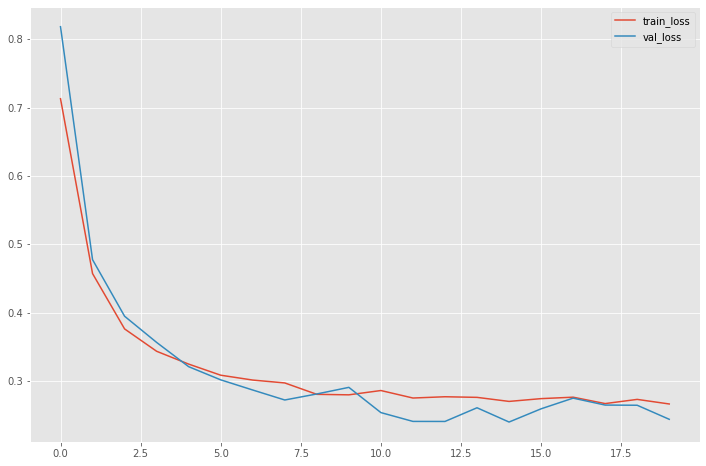

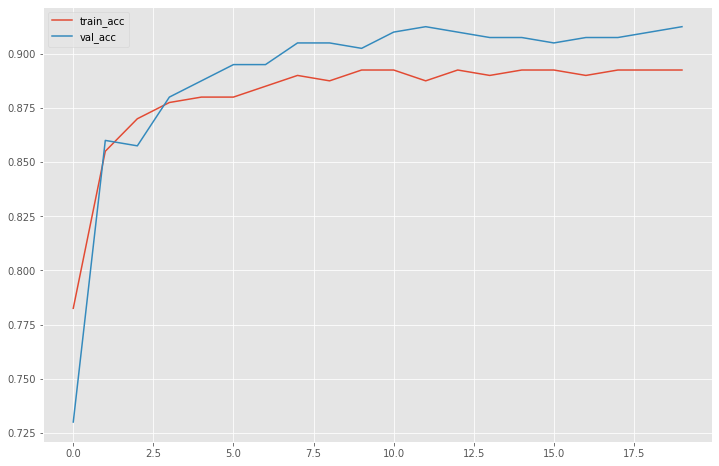

In [43]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.show()

# Test Model (20 Points)

In [47]:
def confusion_matrix(y_true, y_pred):
    cm = np.zeros((10, 10), dtype=np.int32)
    for i in range(len(y_true)):
        cm[y_true[i]][y_pred[i]] += 1
    return cm

10000
Test Loss: 0.8942, Test Accuracy: 0.71%


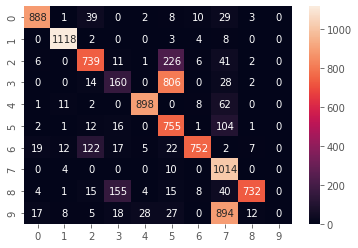

In [54]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

cm = []
test_loss = 0.0
test_acc = 0.0
# test model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # save epoch metrics
        test_loss += loss.item()
        test_acc += accuracy(outputs, labels)



        # plot confusion matrix
        cm.append(confusion_matrix(labels.cpu(), torch.argmax(outputs, dim=1).cpu()))

# print validation metrics
print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.
        format(test_loss / len(cm), test_acc / len(cm)))
        
res = cm[0]
for c in cm[1:]:
    res += c

sns.heatmap(res, annot=True, fmt='d')
plt.show()